# **Download Data in Kaggle**

In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"nguynminhphng","key":"9aebbd96a156d449a7a6a8eedea7897a"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

500 - An internal server error occurred. Please ensure that your API client is up to date. If it is, please report a bug at github.com/Kaggle/kaggle-api


In [ ]:
!kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset

supervisely-filtered-segmentation-person-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
!unzip supervisely-filtered-segmentation-person-dataset.zip -d train

In [ ]:
import tensorflow as tf
INPUT_SHAPE = 512
OUTPUT_SHAPE = 512

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=[512, 512, 3], include_top=False)

# # Use the activations of these layers

layer_names = [
    'conv1_relu',   # (None, 256, 256, 96)
    'conv2_block3_out',   # (None, 128, 128, 256)
    'conv3_block4_out',   # (None, 64, 64, 516)
    'conv4_block6_out',  # (None, 32, 32, 1024)
    'conv5_block3_out',      # (None, 16, 16, 2048)
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
def _upsample_cnn_block(block_input, block_counterpart, channel):  
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
  conv1 = tf.keras.layers.BatchNormalization()(conv1)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(conv1)
  return conv2

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def _create_model(output_channels: int):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])
  ds_blocks = down_stack(inputs)

  us_block4 = _upsample_cnn_block(ds_blocks[-1], ds_blocks[-2], channel=512)


  us_block3 = _upsample_cnn_block(us_block4, ds_blocks[-3], channel=256)
  us_block2 = _upsample_cnn_block(us_block3, ds_blocks[-4], channel=128)
  us_block1 = _upsample_cnn_block(us_block2, ds_blocks[-5], channel=64)
  
  us_block0 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2,padding='same')(us_block1)
  us_block0 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(us_block0)
  us_block0 = tf.keras.layers.BatchNormalization()(us_block0)
  us_block0 = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=1, strides=1, padding='same', activation='sigmoid')(us_block0)
  model = tf.keras.models.Model(inputs = inputs, outputs = us_block0)
  model.compile(optimizer=Adam(learning_rate = 1e-4), loss=dice_coef_loss, metrics=['accuracy',iou_coef])
  return model

model = _create_model(2)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            [(None, 256, 256, 64 23587712    input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_13 (Conv2DTran (None, 32, 32, 512)  4194816     model_3[0][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 32, 32, 1536) 0           model_3[0][3]                    
                                                                 conv2d_transpose_13[0][0]  

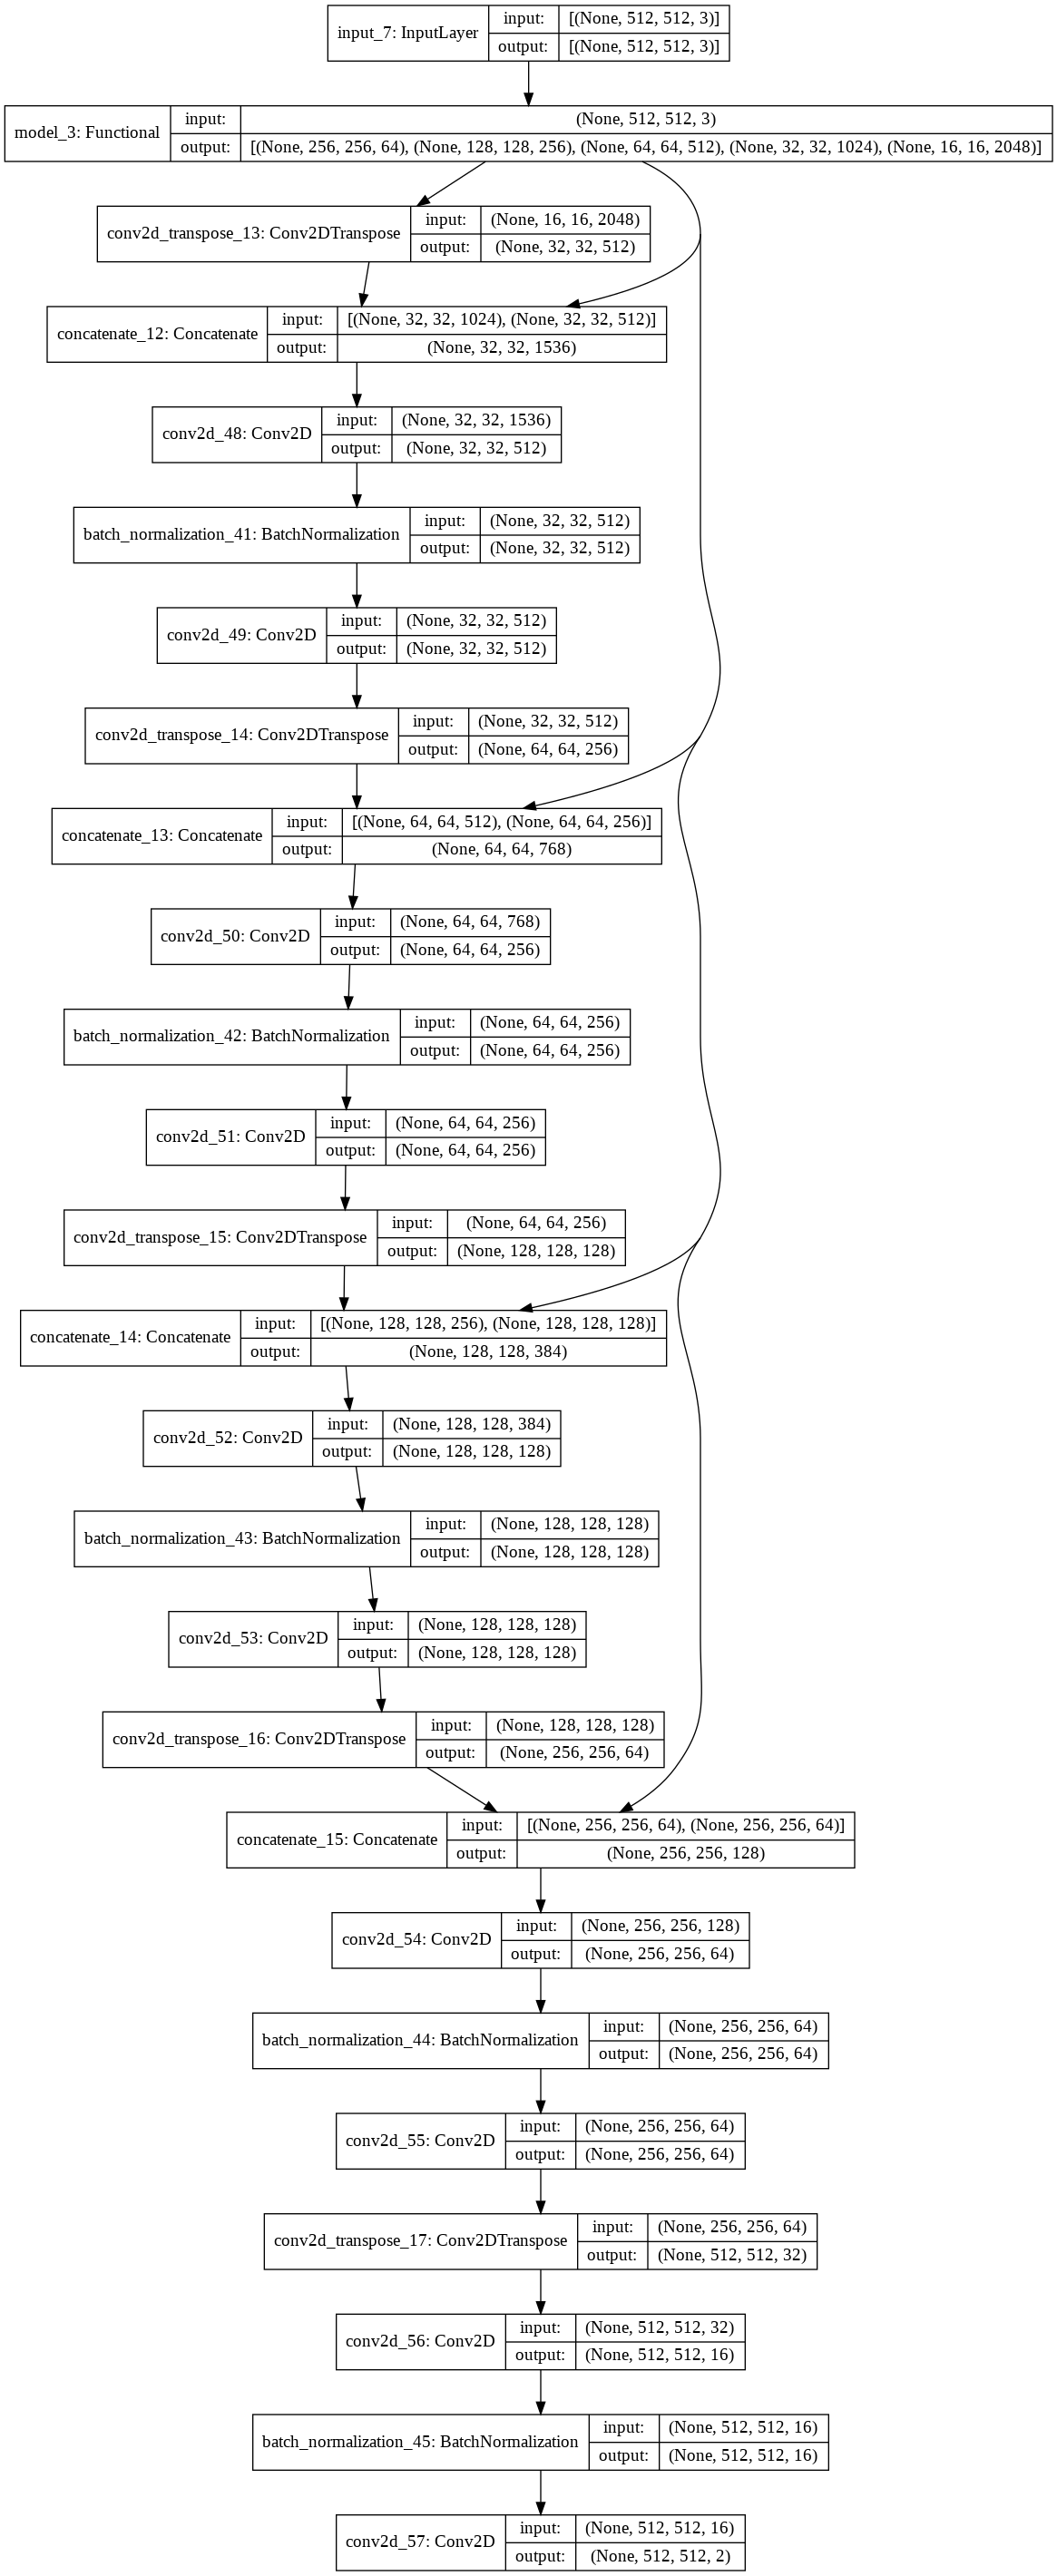

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import os
image_links=[]
for dirname, _, filenames in os.walk('/content/train/supervisely_person_clean_2667_img/images'):
    for filename in filenames:
        image_links = image_links+[os.path.join(dirname, filename)]
        
mask_links=[]
for dirname, _, filenames in os.walk('/content/train/supervisely_person_clean_2667_img/masks'):
    for filename in filenames:
        mask_links = mask_links+[os.path.join(dirname, filename)]
        
print("Length of Image links"+" "+str(len(image_links)))
print("Length of Masks links"+" "+str(len(mask_links)))

train_img_paths = image_links[:2000]
train_label_paths = mask_links[:2000]
val_img_paths = image_links[2000:]
val_label_paths = mask_links[2000:]

Length of Image links 2667
Length of Masks links 2667


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 input_dim,
                 n_channels,
                 normalize,
                 zoom_range, 
                 rotation,
                 brightness_range,
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        normalize: Chuẩn hóa ảnh
        zoom_range: Kích thước scale
        rotation: Độ xoay của ảnh
        brightness_range: Độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, Y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, Y = self.__data_generation(all_filenames_temp)

        return X, Y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.input_dim, 2))

        # Khởi tạo dữ liệu
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            label = cv2.imread(label_fn)
            img = cv2.resize(img, self.input_dim)
            label = cv2.resize(label, self.input_dim)
          
            if self.normalize:
              mean1 = np.mean(img, axis=0)
              std1 = np.std(img, axis=0)
              img = (img-mean1)/std1

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = cv2.resize(label, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = label/255
              label[label > 0.5] = 1
              label[label < 0.5] = 0
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
              label = label[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))
              label = cv2.warpAffine(label, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright

            label1 = label > 0.5
            label2 = label < 0.5
            
            X[i,] = img
            Y[i,] = np.concatenate((label1[:,:,0,np.newaxis],label2[:,:,0,np.newaxis]),axis=-1)
        return X, Y

In [ ]:
train_generator = DataGenerator(
    all_filenames = list(zip(train_img_paths, train_label_paths)),
    labels = train_label_paths,
    batch_size = 8,
    input_dim = (512, 512),
    n_channels = 3,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

In [ ]:
val_generator = DataGenerator(
    all_filenames = list(zip(val_img_paths, val_label_paths)),
    labels = val_label_paths,
    batch_size = 8,
    input_dim = (INPUT_SHAPE, INPUT_SHAPE),
    n_channels = 3,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

X_batch, Y_batch = train_generator.__getitem__(index=0)
print(X_batch.shape, Y_batch.shape)

(8, 512, 512, 3) (8, 512, 512, 2)


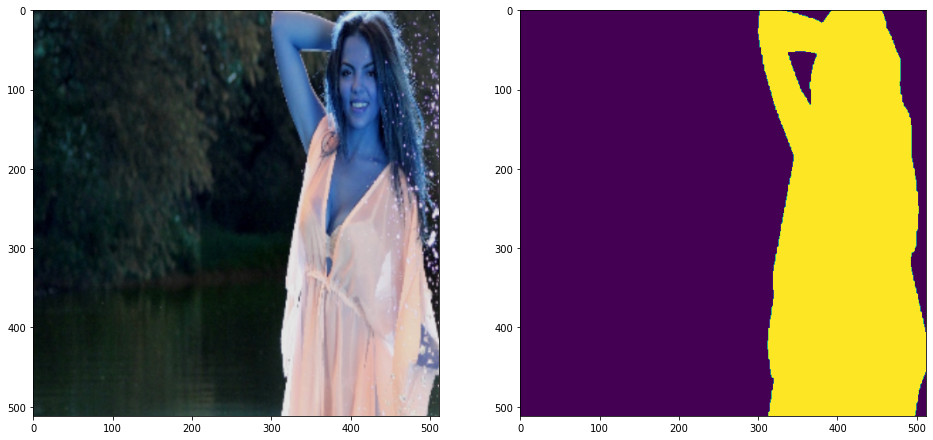

In [ ]:
import matplotlib.pyplot as plt
# Khởi tạo subplot với 1 dòng 2 cột.
rand_ind = np.random.randint(8)

plt.subplots(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_batch[rand_ind]/255)
plt.subplot(122)
plt.imshow(Y_batch[rand_ind,:,:,0])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
history = model.fit_generator(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=100,
          callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
          )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
250/250 [==============================] - 364s 1s/step - loss: 0.0573 - accuracy: 0.9037 - iou_coef: 0.6961 - val_loss: 0.0519 - val_accuracy: 0.9201 - val_iou_coef: 0.7403
Epoch 2/100
250/250 [==============================] - 351s 1s/step - loss: 0.0352 - accuracy: 0.9405 - iou_coef: 0.7849 - val_loss: 0.0299 - val_accuracy: 0.9482 - val_iou_coef: 0.8253
Epoch 3/100
250/250 [==============================] - 351s 1s/step - loss: 0.0297 - accuracy: 0.9491 - iou_coef: 0.8157 - val_loss: 0.0181 - val_accuracy: 0.9693 - val_iou_coef: 0.8735
Epoch 4/100
250/250 [==============================] - 352s 1s/step - loss: 0.0269 - accuracy: 0.9535 - iou_coef: 0.8335 - val_loss: 0.0268 - val_accuracy: 0.9530 - val_iou_coef: 0.8366
Epoch 5/100
250/250 [==============================] - 358s 1s/step - loss: 0.0253 - accuracy: 0.9558 - iou_coef: 0.8482 - val_loss: 0.0249 - val_accuracy: 0.9551 - val_iou_coef: 0.8645
Epoch 6/100
250/250 [==============================] - 355s 1s/step - 

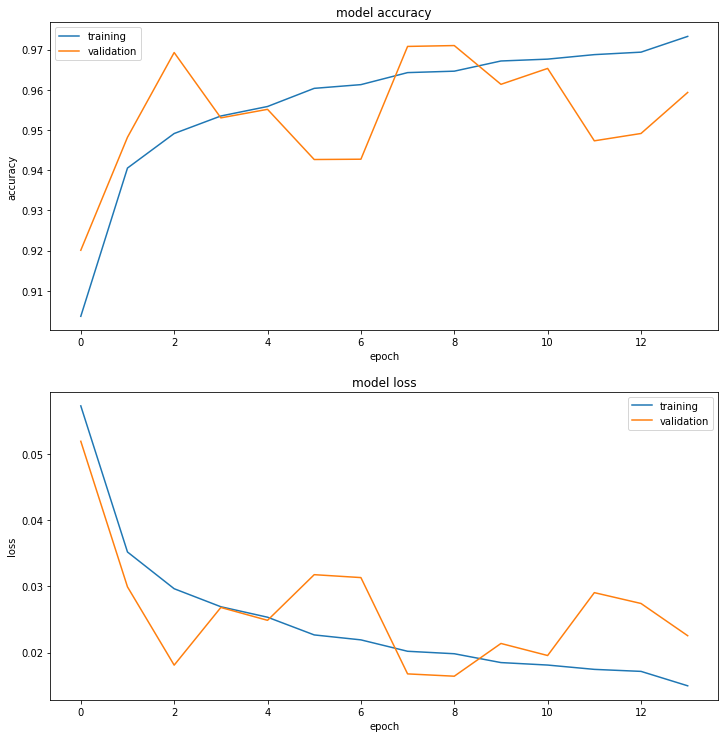

In [ ]:
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

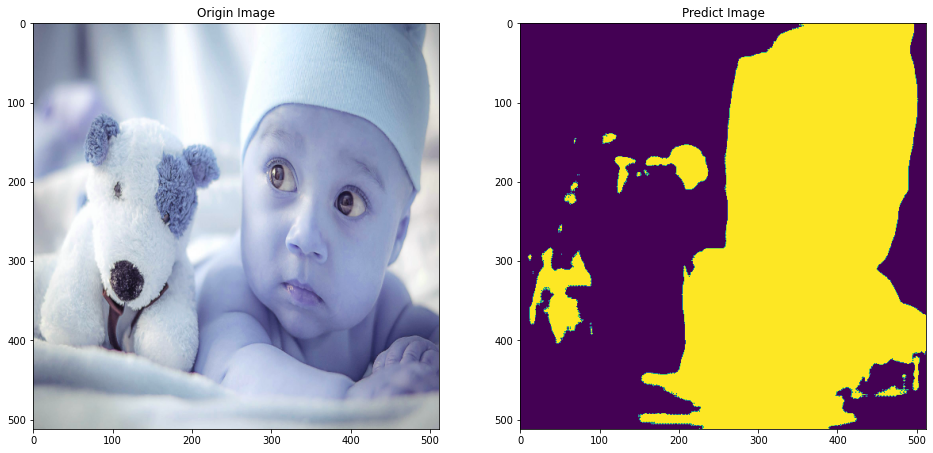

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

rand_ind = np.random.randint(2000)
path = image_links[rand_ind]

def _predict_path(path, figsize = (16, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]
  img_pred = model.predict(img_expand).reshape(OUTPUT_SHAPE, OUTPUT_SHAPE,2)
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1
  plt.subplots(figsize = figsize)
  plt.subplot(122)
  plt.title('Predict Image')
  plt.imshow(img_pred[:,:,0])
  plt.subplot(121)
  plt.title('Origin Image')
  plt.imshow(img)
  

_predict_path(path)

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("/content/drive/MyDrive/Colab Notebooks/model.h5")
print("Save model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Save model to disk


In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
load_model = model_from_json(loaded_model_json)

load_model.load_weights('/content/drive/MyDrive/model.h5')
print("loaded model from disk")

loaded model from disk


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
INPUT_SHAPE = 512
OUTPUT_SHAPE = 512

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5')

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def _predict_path(path, figsize = (16, 8)):
  img = cv2.imread(path)
  img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
  img_expand = img[np.newaxis, ...]
  img_pred = model.predict(img_expand).reshape(OUTPUT_SHAPE, OUTPUT_SHAPE,1)
  img_pred[img_pred < 0.5] = 0
  img_pred[img_pred >= 0.5] = 1

  img_background = cv2.imread('/content/drive/MyDrive/bg.jpg')
  img_background = cv2.resize(img_background, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

  img_cut = np.empty((OUTPUT_SHAPE,OUTPUT_SHAPE,3),dtype=int)
  for i in range(0,3):
    img_cut[:,:,i] = np.multiply(img[:,:,i],img_pred[:,:,0])+ np.multiply(img_background[:,:,i],1-img_pred[:,:,0])
  plt.subplots(figsize = figsize)
  plt.subplot(122)
  plt.title('Predict Image')
  plt.imshow(img_cut)
  plt.subplot(121)
  plt.title('Origin Image')
  plt.imshow(img)
  cv2.imwrite('/content/filename.jpg', img_cut)
  
_predict_path('/content/drive/MyDrive/Ảnh/Hương lép.jpg')

NameError: ignored